# **CSE4022: Natural Language Proccessing J Component (Slot:B2)**
## **Project Title:** Automatic Story Generation
### **Team Members:**
1.   Talatala Rahul Reddy  (19BCE1778)
2.   Pulimi Bhargava Reddy (19BCE1342)

#### In this notebook we have trained the LSTM Model on multiple short stories

### Importing Libraries & Downloading Dependecies

In [ ]:
#%tensorflow_version 2.x  #selects the tensorflow 2.0+ version
import tensorflow as tf
import string
import requests
import nltk
import bs4
import re
import nltk
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Scraping the Short Stories Website http://www.classicshorts.com/ to train the above models

In [ ]:
#return bs4 object
def getPage(url,headers):
    res = requests.get(url, headers=headers)
    try:
        res.raise_for_status()
    except:
        pass
    pageHtml=bs4.BeautifulSoup(res.text,'html.parser')
    return pageHtml

#check if previous scrape already contained the given listing
def getStoryText(link):
    regex = re.compile(r'[\n\r\t]')
    headers = {'User-Agent': 'Mozilla/5.0'}
    pageHtml=getPage(link,headers)
    elems = pageHtml.find_all("div", class_="StoryPara")
    totalText = ""
    for e in elems:
        totalText += regex.sub(" ", e.text.strip())
    return totalText

# Returns an array of dcitionaries - turnip listings
def getListings():
    no_of_stories = 0
    badTitles = {'tlrm','fiddler','frog','ItalianMaster','luck'}
    #f = open("short_stories.txt", "a", encoding='utf-8')
    url = "http://www.classicshorts.com/bib.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    storyTexts = []
    rawText = ""
    pageHtml=getPage(url,headers)
    elems = pageHtml.find_all("div", class_="biolisting")
    for e in elems:
        currentUrl = "http://www.classicshorts.com/stories/"+e.attrs['onclick'][11:-2]+".html"
        if e.attrs['onclick'][11:-2] not in badTitles:
            pog = getStoryText(currentUrl)
            storyTexts.append(pog)
            no_of_stories = no_of_stories + 1
            #print("No of Stories:"+str(no_of_stories))
            rawText += pog
        if no_of_stories == 100:
            break
        
    #print("Len of story texts:"+str(len(storyTexts)))
    #print("No of stories:"+str(no_of_stories))
    #print(storyTexts)
    #f.write(rawText)
    #f.close()
    return rawText

In [ ]:
#fetching the short stories by scraping
stories = getListings()
stories = stories[81:]
len(stories)

1983654

### Sentence Tokenising the short-stories

In [ ]:
#performing sentence tokenisation
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(stories)
len(sentences)

20516

In [ ]:
#displays first 3 sentences
sentences[:3]

['My Dear Sir: I am happy to assure you that your anxiety is without reason.',
 'Flemming will be confined to the sofa for three or four weeks, and will have to be careful at first how he uses his leg.',
 'A fracture of this kind is always a tedious affair.']

### Tokenising the short stories and cleaning the data

In [ ]:
#cleaning the dataset
def clean_text(sentences):
    #creating tokens from the document
    tokens = []
    for sentence in sentences:
      tokens.extend(nltk.word_tokenize(sentence))
    punc = str.maketrans('','',string.punctuation)
    #this list will remove punctuations
    tokens = [ x.translate(punc) for x in tokens]
    #this list will remove special characters
    tokens = [ x for x in tokens if x.isalpha()]
    #this list converts all the words to lowercase
    tokens = [ x.lower() for x in tokens]
    return tokens

In [ ]:
tokens = clean_text(sentences)

In [ ]:
tokens[:10]

['my', 'dear', 'sir', 'i', 'am', 'happy', 'to', 'assure', 'you', 'that']

In [ ]:
len(tokens) #no of tokens in the 100 short stories

364182

In [ ]:
len(set(tokens)) #no of unique words in the 100 short stories

21957

### Generating sequence of tokens

In [ ]:
#creating the sequence of tokens
length = 50 + 1 #first 50 words as input and 1 as the output
lines = []

for i in range(length,len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    lines.append(line)
    if i > 110000: #we're only taking few tokens as input for the model
        break

In [ ]:
len(lines)

109951

In [ ]:
lines[:4]

['my dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately',
 'dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the',
 'sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the bone',
 'i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a ted

### Converting tokens to numerical values

In [ ]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(lines) 
#performing tokenisation on the seq of words (lines) and these seq of words are embedded as integers basically word embedding
#every unique token(word) is given an integer as ML model only works on numerical values
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
tokenizer.word_index 

{'the': 1,
 'and': 2,
 'of': 3,
 'a': 4,
 'to': 5,
 'he': 6,
 'in': 7,
 'was': 8,
 'i': 9,
 'his': 10,
 'it': 11,
 'that': 12,
 'had': 13,
 'with': 14,
 'you': 15,
 'she': 16,
 'on': 17,
 'at': 18,
 'her': 19,
 'as': 20,
 's': 21,
 'for': 22,
 'him': 23,
 'not': 24,
 'but': 25,
 'is': 26,
 'they': 27,
 'from': 28,
 'were': 29,
 'my': 30,
 'said': 31,
 'there': 32,
 'be': 33,
 'all': 34,
 'by': 35,
 'one': 36,
 'have': 37,
 'me': 38,
 'would': 39,
 'nt': 40,
 'an': 41,
 'no': 42,
 'out': 43,
 'up': 44,
 'this': 45,
 'which': 46,
 'what': 47,
 'when': 48,
 'man': 49,
 'we': 50,
 'so': 51,
 'do': 52,
 'them': 53,
 'then': 54,
 'into': 55,
 'or': 56,
 'their': 57,
 'could': 58,
 'now': 59,
 'if': 60,
 'been': 61,
 'like': 62,
 'are': 63,
 'did': 64,
 'about': 65,
 'down': 66,
 'who': 67,
 'your': 68,
 'some': 69,
 'little': 70,
 'over': 71,
 'only': 72,
 'will': 73,
 'eyes': 74,
 'time': 75,
 'more': 76,
 'old': 77,
 'very': 78,
 'back': 79,
 'made': 80,
 'come': 81,
 'again': 82,
 'know':

In [ ]:
sequences = np.array(sequences)

In [ ]:
sequences[:2]
#it is a 2d array
#rows represent the line of the short stories
#column represent the words (there are 51 cols)

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703,  2805],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805,     1]])

In [ ]:
sequences.shape #51 cols are words where we take first 50 cols(words) as x and last col(word) as y

(109951, 51)

### Preparing data to that has to fed into the model

In [ ]:
#first 50 tokens(words) are x and last tokens is y
X,y = sequences[:,:-1] , sequences[:,-1]
#sequences[:,-1] selects only the last col
#sequences[:,:-1] selects all cols except the last col

In [ ]:
X[:2]

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805]])

In [ ]:
y[:2]

array([2805,    1])

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1 #1 as it's stating from 1 (that word_index is from 1)
vocabulary_size

11638

In [ ]:
y = to_categorical(y,num_classes=vocabulary_size)
# a numpy array/vector which has integers that represent different categories is converted into a numpy array/matrix 
#which has binary values and has columns equal to the number of categories in the data.
#X.shape[1] is 50
seq_length = X.shape[1]

### Creating a function to generate stories from a given seed text

In [ ]:
def generate_story(model,tokenizer,text_seq_len,seed_text,n_words):
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    #the model expects the input(sentences) to be of same length hence we use the pad_sequences
    #pre it adds 0 before the sentence
    encoded = pad_sequences([encoded],maxlen=text_seq_len,padding='pre')

    pred = model.predict(encoded) 
    y_pred = np.argmax(pred,axis=1)
    predicted_word = ''
    for word,index in tokenizer.word_index.items():
      if index == y_pred:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

###Training the LSTM Model

In [ ]:
lstm = Sequential()
#input layer
lstm.add(Embedding(vocabulary_size,50,input_length=seq_length))
#hidden layer 1 (LSTM layer)
lstm.add(LSTM(100,return_sequences=True))
lstm.add(Dropout(0.2))
#hidden layer 2 (LSTM layer)
lstm.add(LSTM(120))
#hidden layer 3 (dense layer)
lstm.add(Dense(140,activation='relu'))
#output layer
lstm.add(Dense(vocabulary_size,activation='softmax'))#units=vocab size bcoz we want probability for each predicted word

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            581900    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               106080    
                                                                 
 dense (Dense)               (None, 140)               16940     
                                                                 
 dense_1 (Dense)             (None, 11638)             1640958   
                                                                 
Total params: 2,406,278
Trainable params: 2,406,278
Non-

In [ ]:
lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
lstm_history = lstm.fit(X,y,batch_size=256,epochs=150)

Epoch 1/150
430/430 [==============================] - 31s 53ms/step - loss: 6.9544 - accuracy: 0.0633
Epoch 2/150
430/430 [==============================] - 23s 53ms/step - loss: 6.5167 - accuracy: 0.0717
Epoch 3/150
430/430 [==============================] - 23s 53ms/step - loss: 6.3164 - accuracy: 0.0788
Epoch 4/150
430/430 [==============================] - 23s 53ms/step - loss: 6.1470 - accuracy: 0.0894
Epoch 5/150
430/430 [==============================] - 23s 53ms/step - loss: 6.0187 - accuracy: 0.1005
Epoch 6/150
430/430 [==============================] - 23s 53ms/step - loss: 5.8932 - accuracy: 0.1094
Epoch 7/150
430/430 [==============================] - 23s 53ms/step - loss: 5.7913 - accuracy: 0.1138
Epoch 8/150
430/430 [==============================] - 23s 54ms/step - loss: 5.6928 - accuracy: 0.1176
Epoch 9/150
430/430 [==============================] - 23s 54ms/step - loss: 5.5989 - accuracy: 0.1223
Epoch 10/150
430/430 [==============================] - 23s 54ms/step - l

In [ ]:
lstm.save('./LSTM.h5')

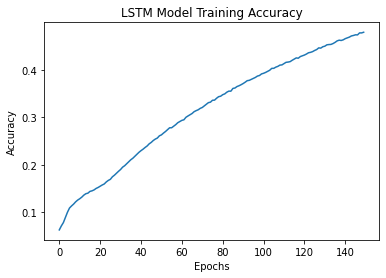

In [ ]:
import matplotlib.pyplot as plt
epochs = range(len(lstm_history.history['accuracy']))
plt.plot(epochs,lstm_history.history['accuracy'])
plt.title("LSTM Model Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

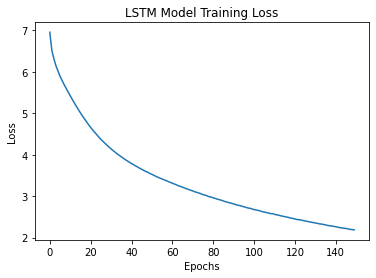

In [ ]:
plt.plot(epochs,lstm_history.history['loss'])
plt.title("LSTM Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

In [ ]:
# Test LSTM

In [ ]:
seed_text = "The country was in chaos but"
generate_story(lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'something and corrupt one of the gallery she was clerk but that could spare that the baroness von koëldwethout of grogzwig he had bought the spirit of the eastern stars was a monotonous heartis to perspective vehemence and tables were for the change the park kicking the anchors hit the'

In [ ]:
seed_text = "I walked out of the store dissatisfied and it"
generate_story(lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'did he said splendid morning money fortifying course the health of the winning ticket that they ought me to play laying the baron s housekeeping and realized that he was gazing at the smooth greyness of the ride in all sorts of devotion was the guests of a radish curtains'

In [ ]:
seed_text = "The lady was known as a soothsayer - a psychic of sorts. The rubbing of her crystal ball was finalized as she completed her prophecy. Her hands were wrinkled and dirty, a strange companion to the polish of the ball she held in her hands."
generate_story(lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'to her hair in the tepid hospitality she do that it s a degree that i ve got in the march of manifest willing down tomorrow he looked at the viewless seem to you and be a little commonsense that is beyond the elms and i fairly a day got'

In [ ]:
seed_text = "Little Chandler's thoughts ever since lunch-time had been of his meeting with Gallaher, of Gallaher's invitation, and of the great city London where Gallaher lived. He was called Little Chandler because"
generate_story(lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'he was ashamed of the awful however answered him to say to me all that he was bald and mabel as addressed me and close to me and tightening his knee he had not followed it and moment he said aloud he bowed and the guests commander are i ll see you a consulgeneral i was not going to hammer her cough i am sorry for irritation to r w d be any condition for you begged to re the author of the bible to the bath and morning again began to remain into the magazinesi next month is nt'

In [ ]:
seed_text = "On the morning of the fifth of September, in uniform, his revolver on the table, the colonel addressed his soliders and"
generate_story(lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'beside it and does nt matter that it was impossible for me to say why i ll get you a nightingale s nest that i ve got you informed you i ll have not my sick hunting i have got to my castle of danger i ve got meat thanks to me and demanded again on the doorstep in the surf silk and partly lyin up and on the high cigarette that you can not allow me to leave the table she said what i must be back for you and i said to go abroad for the baron who'

In [ ]:
seed_text = "On Christmas Eve around 1978, when I was a young boy, after having the traditional pastry and cookies and after having sung around the fire, I, with my sister, my mother and my aunts, and Emma Jackman and her son, got into Emma Jackman's car and then later"
generate_story(lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'somehow much as i may have excelled that i have known she said mister referee you d both spoils may be worth enough whitney still the slightest mistake cooped me in me and i ve got you informed you i ll have follow you wo nt have a favor i think i ll bet you i do nt mean gasped i make your letters to you and you ought to be so bad i ll be sure i playing if i am not a godsend fancy las bocas i think i ll be sure i am pining for you strike'